# Census Data

There are four variables inside the census dictionary

 - X (containing X[0] and X[1])
    - X[0] is the shape integral inputs (for big areas)
    - Y[0] are the number of people in each
    - X[1] is the location of house sales
    - X[1] is whether the house is small (a flat or terrace) or big (a semi-detached or detached house)
 - oaX are the shape integral inputs for tiny 'output areas'
 - oaY are the number of people in each
 - volumes = area (in km^2) of each training (X) area
 - oavolumes = area (in km^2) of each output area (oaX)

In [75]:
#run this to get the pickle file out the zip
#!tar -xzvf census.zip

In [76]:
import pickle
import numpy as np
census_demo_data = pickle.load(open('census_demo_data.p','rb'))

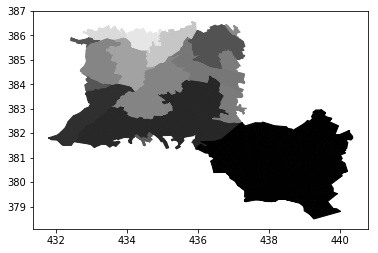

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotsimplexes(X,col=None,lw=1):
    for c,x in zip(col,X):
        edges = []
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.fill(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c)
        else:
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
#The combined Output areas
#the shades of grey refer to the population density
colours = (census_demo_data['Y'][0][:,0]/census_demo_data['volumes'])[:,None]
colours = 0.9*colours/np.max(colours)
colours = np.c_[colours,colours,colours]
plotsimplexes(census_demo_data['X'][0],colours)

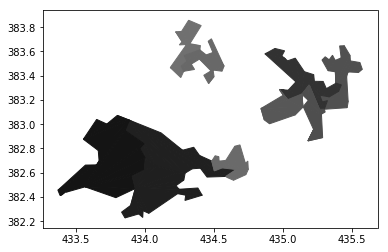

In [78]:
#The output areas
colours = (census_demo_data['oaY'][:,0]/census_demo_data['oavolumes'])[:,None]
colours = colours/(np.max(colours)/3)
colours[colours>0.9]=0.9
colours = np.c_[colours,colours,colours]
plotsimplexes(census_demo_data['oaX'][0:10,:],colours[0:10,:]) #just plotting first 10.

# Air Pollution Data

There are four variables inside the air pollution dictionary

 - X (containing X[0] and X[1])
    - X[0] is the intervals for the high-quality, low-frequency reference instrument (a turnkey osiris sensor https://turnkey-instruments.com/product/osiris/)
    - Y[0] are the PM2.5 SUMS (so this is the density, PM2.5 x time)
    - X[1] are the intervals for the low-quality, high-frequency cheap instrument (a pms5003 http://www.aqmd.gov/docs/default-source/aq-spec/resources-page/plantower-pms5003-manual_v2-3.pdf)
    - X[1] are the values (scaled by the intervals!)
    
I've had to scale the data in the plots - this is because the Ys are all densities (so the integrals can be used straight away with the integral kernel).

In [79]:
import pickle
import numpy as np
air_demo_data = pickle.load(open('air_pollution_demo_data.p','rb'))

In [ ]:
X = air_demo_data['X']
Y = air_demo_data['Y']
testX = air_demo_data['testX']
testY = air_demo_data['testY']

In [ ]:
import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
#from hetmogp.model import HetMOGP
from hetmogp.svmogp import SVMOGP
#from hetmogp import multi_output
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import GPy
import matplotlib.pyplot as plt

from hetmogp.likelihoods.bernoulli import Bernoulli
from hetmogp.likelihoods.gaussian import Gaussian
from hetmogp.likelihoods.categorical import Categorical
from hetmogp.likelihoods.hetgaussian import HetGaussian
from hetmogp.likelihoods.beta import Beta
from hetmogp.likelihoods.gamma import Gamma
from hetmogp.likelihoods.exponential import Exponential

M = 10  # number of inducing points
Q = 1  # number of latent functions

# Heterogeneous Likelihood Definition
# likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
#likelihoods_list = [Bernoulli(), Bernoulli()] # Real + Binary
likelihoods_list = [Gaussian(sigma=0.1),Gaussian(sigma=0.01)]

likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

#W_list, _ = multi_output.random_W_kappas(Q, D, rank=1, experiment=True)
W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

from hetmogp.error_func import snlp, smse, mae

# KERNELS
input_dim = 3
Q = 1
ls_q = np.array(([2.0]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lengthscale=[ls_q], variance=[var_q], input_dim=input_dim,kernel=GPy.kern.Mix_Integral_)

def callback(i):
    print(i)
    if i['n_iter'] > 4000:
        return True
    return False

X_ = np.vstack((X[0], X[1]))
from sklearn.cluster import KMeans
#kmeans_X = KMeans(n_clusters=100, random_state=0).fit(X_)
#Z = kmeans_X.cluster_centers_
Ninducing = 500
Z = np.zeros([Ninducing,X_.shape[1]])
Z[:,-1] = 1
Z[:,0] = np.linspace(0,24*5,Ninducing)

model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=70)
model.Z.fix()

model.kern.lengthscale.fix(0.5)
model.kern.variance = 5000 #.fix(5000)
model.kern_q0.lengthscale.fix(0.5)
model.kern_q0.variance = 5000#.fix(5000)

#vem_model=VEM(model,vem_iters=30,maxIter_perVEM=30,optZ=False,verbose=True,verbose_plot=False,non_chained=True)
import climin
opt = climin.Adam(model.optimizer_array,model.stochastic_grad,step_rate=0.1,decay_mom1=1-0.9, decay_mom2=1-0.999)
opt.minimize_until(callback)

 /home/ubuntu/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /home/ubuntu/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/ubuntu/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


{'n_iter': 1, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 1.00000490e-001,  1.00000490e-001,  1.00000490e-001, ...,
       -1.00000490e-001,  8.03923814e-295,  9.87287361e-294]), 'offset': 1e-08, 'est_mom1_b': array([ 1.38892017e+000,  4.56830669e+000,  3.02034925e+000, ...,
       -2.40563051e+002,  8.03923894e-303,  9.87287460e-302]), 'est_mom2_b': array([1.92909925e-01, 2.08694260e+00, 9.12250958e-01, ...,
       5.78705814e+03, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([ 1.38892017e+001,  4.56830669e+001,  3.02034925e+001, ...,
       -2.40563051e+003,  8.03923894e-302,  9.87287460e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 2, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([6.94613601e-002, 6.94643803e-002, 6.94582806e-002, ...,
       7.31667953e-002, 8.03915424e-295, 9.87116454e-294]), 'offset': 1e-08, 'est_mo

{'n_iter': 13, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.63682770e-002, 3.63732424e-002, 3.62738188e-002, ...,
       6.05636600e-002, 8.03920762e-295, 9.85860214e-294]), 'offset': 1e-08, 'est_mom1_b': array([1.40186981e+003, 4.59479372e+003, 3.30404372e+003, ...,
       3.98941548e+005, 5.99574899e-302, 7.35267785e-301]), 'est_mom2_b': array([3.45182825e+05, 3.70721069e+06, 1.92745513e+06, ...,
       1.00803028e+10, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([1.12091054e+002, 3.69094520e+002, 2.43448817e+002, ...,
       1.28111742e+006, 8.03969344e-302, 9.97130275e-301]), 'args': [], 'kwargs': {}}


In [ ]:
plt.figure(figsize=[15,12])
plt.subplot(2,1,1)
plt.plot(X[1][:,0],Y[1]/np.median(X[1][:,0]-X[1][:,1]),'g-')
plt.title('Colocated low-cost sensor')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.title('Reference sensor data and prediction')
means,variances = model.predict(testX1)
mean = means[0]
var = variances[0]
plt.plot(testX1[:,0],4*mean,'b-',label='prediction')
plt.plot(testX1[:,0],4*mean+4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX1[:,0],4*mean-4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX[:,0],testY,'r-',label='true') #test data red line

stepsize = X[0][1][0]-X[0][0][0]
lab = 'training data'
for x1,y1 in zip(X[0],Y[0]):
    #plt.plot([lr[0],lr[0]+stepsize,lr[0]+stepsize,lr[0],lr[0]],[0,0,lr[1],lr[1],0],'r-')
    plt.plot([x1[0],x1[0]-stepsize,x1[0]-stepsize,x1[0],x1[0]],[0,0,y1/3,y1/3,0],'r-',label=lab)
    lab = None
plt.legend()
plt.grid()
plt.vlines(model.Z,0,1)
plt.ylim([0,20])
plt.xlim([X[0][0,1],X[0][-1,0]])